In [2]:
import pickle 
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
import pandas as pd

# 1. 定义要加载的文件的路径
filename_to_load = "NoisyAG-News.pkl"

# 2. 使用 pd.read_pickle() 加载文件
# 我们将加载后的数据存放在一个新的变量中，例如 df_loaded
try:
    df = pd.read_pickle(filename_to_load)
    
except FileNotFoundError:
    print(f"❌ 错误: 文件 '{filename_to_load}' 未找到。请确保文件名和路径正确。")
    
print(df.columns)

Index(['sample_index', 'text', 'ground_truth', 'human_label_1',
       'human_label_2', 'human_label_3', 'human_best_label',
       'human_middle_label', 'human_worst_label', 'gemini_2.5_pro_label',
       'gpt4_label', 'claude4_label', 'SOTA_llm_best_label',
       'SOTA_llm_middle_label', 'SOTA_llm_worst_label', 'mistral_3b_label',
       'mistral_8b_label', 'mistral_latest_label', 'mistral_multi_best_label',
       'mistral_multi_middle_label', 'mistral_multi_worst_label',
       'mistral_8b_temp1.5_run1', 'mistral_8b_temp1.5_run2',
       'mistral_8b_temp1.5_run3', 'mistral_8b_best_label',
       'mistral_8b_middle_label', 'mistral_8b_worst_label',
       'noise_instance_best', 'noise_instance_med', 'noise_instance_worst',
       'noise_sameNTM_best', 'noise_sameNTM_med', 'noise_sameNTM_worst',
       'noise_single_best', 'noise_single_med', 'noise_single_worst',
       'noise_uniform_best', 'noise_uniform_med', 'noise_uniform_worst'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

# --- 1. 配置与设置 ---
# ==============================================================================
# 文件和列名配置
FILE_PATH = 'NoisyAG-News_regenerated.pkl'
LLM_COLUMN = 'gemini_2.5_pro_label'  # 我们选择分析的LLM列
GT_COLUMN = 'ground_truth'

# 标签编码 (请根据您的数据集实际情况确认，通常 AG-News 如下)
# 1: World, 2: Sports, 3: Business, 4: Sci/Tech
# 如果是 0-indexed，则是 0, 1, 2, 3
# 假设是 0-indexed: 0:World, 1:Sports, 2:Business, 3:Sci/Tech
SCI_TECH_LABEL = 3
BUSINESS_LABEL = 2

# 要提取的关键词数量
NUM_KEYWORDS_TO_EXTRACT = 50

# --- 2. 定义核心集合 ---
# ==============================================================================
print("--- 步骤 1: 定义并构建核心集合 ---")

try:
    df = pd.read_pickle(FILE_PATH)
    print(f"✅ 文件 '{FILE_PATH}' 加载成功，共 {len(df)} 条样本。")
except FileNotFoundError:
    print(f"❌ 错误：文件 '{FILE_PATH}' 未找到。请确保文件路径正确。")
    exit()

# 筛选出所有真实标签为 Sci/Tech 的样本
sci_tech_samples = df[df[GT_COLUMN] == SCI_TECH_LABEL].copy()

# 从中分出“混淆集”和“正确集”
confusion_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == BUSINESS_LABEL].copy()
correct_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == SCI_TECH_LABEL].copy()

print(f"🔍 已构建 '混淆集' (GT=Sci/Tech, LLM=Business)，样本数: {len(confusion_df)}")
print(f"✅ 已构建 '正确集' (GT=Sci/Tech, LLM=Sci/Tech)，样本数: {len(correct_df)}")
print("-" * 50)


# --- 3. 控制变量：基于文本长度的近邻匹配 ---
# ==============================================================================
print("--- 步骤 2: 控制变量 (基于文本长度进行近邻匹配) ---")

# 计算文本长度
confusion_df['text_length'] = confusion_df['text'].str.len()
correct_df['text_length'] = correct_df['text'].str.len()

# 找出较小的集合作为源，较大的作为匹配目标
source_df = confusion_df
target_df = correct_df

print("正在为 '混淆集' 中的每个样本在 '正确集' 中寻找文本长度最接近的匹配项...")

# 使用 numpy 进行高效计算
source_lengths = source_df['text_length'].values
target_lengths = target_df['text_length'].values

matched_indices = []
available_target_indices = list(range(len(target_df)))

# tqdm 用于显示进度条
for i in tqdm(range(len(source_df))):
    source_len = source_lengths[i]
    
    # 计算当前源样本与所有可用目标样本的长度差异
    if not available_target_indices:
        print("警告：目标集样本已用尽，匹配提前结束。")
        break
        
    diffs = np.abs(target_lengths[available_target_indices] - source_len)
    
    # 找到差异最小的目标样本的索引
    best_match_local_idx = np.argmin(diffs)
    best_match_global_idx = available_target_indices.pop(best_match_local_idx) # 匹配后从可用池中移除
    
    matched_indices.append(best_match_global_idx)

# 基于匹配到的索引，创建新的“正确集”
matched_correct_df = correct_df.iloc[matched_indices].copy()

print("✅ 匹配完成！")

# 验证匹配效果
print("\n--- 匹配效果验证 (文本长度统计) ---")
stats = pd.DataFrame({
    '混淆集 (匹配后)': confusion_df['text_length'].describe(),
    '正确集 (匹配后)': matched_correct_df['text_length'].describe()
})
print(stats)
print("观察上方，两组的均值(mean)和标准差(std)应非常接近，证明匹配成功。")
print("-" * 50)


# --- 4. 自动提取“致偏”商业关键词 (差异化TF-IDF分析) ---
# ==============================================================================
print(f"--- 步骤 3: 自动提取前 {NUM_KEYWORDS_TO_EXTRACT} 个 '致偏' 商业关键词 ---")

# 合并两个匹配后的集合的文本，以构建统一的语料库
corpus = pd.concat([
    confusion_df['text'],
    matched_correct_df['text']
])

# 初始化TF-IDF向量化器
# min_df=5 表示一个词至少要在5个文档中出现过才被考虑
# max_df=0.7 表示一个词如果在超过70%的文档中都出现，则被视为过于普遍而被忽略
vectorizer = TfidfVectorizer(
    stop_words='english',
    min_df=5,
    max_df=0.7,
    lowercase=True
)

print("正在使用统一语料库训练TF-IDF模型...")
vectorizer.fit(corpus)

print("正在分别计算两个集合的TF-IDF矩阵...")
tfidf_confusion = vectorizer.transform(confusion_df['text'])
tfidf_correct = vectorizer.transform(matched_correct_df['text'])

# 计算每个词在两个集合中的平均TF-IDF分数
avg_tfidf_confusion = np.array(tfidf_confusion.mean(axis=0)).flatten()
avg_tfidf_correct = np.array(tfidf_correct.mean(axis=0)).flatten()

# 计算信号强度 (Signal Strength)
signal_strength = avg_tfidf_confusion - avg_tfidf_correct

# 创建结果DataFrame
results_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'avg_tfidf_confusion': avg_tfidf_confusion,
    'avg_tfidf_correct': avg_tfidf_correct,
    'signal_strength': signal_strength
})

# 按信号强度降序排序
results_df = results_df.sort_values(by='signal_strength', ascending=False)

print(f"\n✅ 提取完成！以下是信号强度最高的 {NUM_KEYWORDS_TO_EXTRACT} 个关键词：")
print("-" * 50)
print(results_df.head(NUM_KEYWORDS_TO_EXTRACT).to_string())
print("-" * 50)

# 保存关键词列表到文件
keywords_list = results_df.head(NUM_KEYWORDS_TO_EXTRACT)['term'].tolist()
v_biz_path = 'V_biz_keywords.txt'
with open(v_biz_path, 'w') as f:
    f.write('\n'.join(keywords_list))
print(f"🔍 关键词列表已保存到 '{v_biz_path}'")

--- 步骤 1: 定义并构建核心集合 ---
❌ 错误：文件 'NoisyAG-News_regenerated.pkl' 未找到。请确保文件路径正确。
🔍 已构建 '混淆集' (GT=Sci/Tech, LLM=Business)，样本数: 4190
✅ 已构建 '正确集' (GT=Sci/Tech, LLM=Sci/Tech)，样本数: 7757
--------------------------------------------------
--- 步骤 2: 控制变量 (基于文本长度进行近邻匹配) ---
正在为 '混淆集' 中的每个样本在 '正确集' 中寻找文本长度最接近的匹配项...


  6%|▌         | 231/4190 [00:00<00:03, 1061.58it/s]

100%|██████████| 4190/4190 [00:02<00:00, 1999.47it/s]


✅ 匹配完成！

--- 匹配效果验证 (文本长度统计) ---
         混淆集 (匹配后)    正确集 (匹配后)
count  4190.000000  4190.000000
mean    241.957518   241.934845
std      79.736569    79.713825
min     102.000000   102.000000
25%     192.000000   192.000000
50%     235.000000   235.000000
75%     276.000000   276.000000
max     978.000000  1004.000000
观察上方，两组的均值(mean)和标准差(std)应非常接近，证明匹配成功。
--------------------------------------------------
--- 步骤 3: 自动提取前 50 个 '致偏' 商业关键词 ---
正在使用统一语料库训练TF-IDF模型...
正在分别计算两个集合的TF-IDF矩阵...

✅ 提取完成！以下是信号强度最高的 50 个关键词：
--------------------------------------------------
              term  avg_tfidf_confusion  avg_tfidf_correct  signal_strength
3214         music             0.018809           0.004571         0.014238
3003        market             0.015303           0.001863         0.013440
1067       company             0.019530           0.006464         0.013066
3416        oracle             0.013321           0.001647         0.011675
766       business             0.014003         

: 

In [7]:
# 导入所需的核心库
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import mannwhitneyu
from tqdm import tqdm

# --- 0. 初始化：下载NLTK依赖包 ---
# ==============================================================================
# 这段代码会检查并下载NLTK所需的分词器和停用词列表。
# 在您的机器上成功运行一次后，未来即可注释掉。
try:
    stopwords.words('english')
except LookupError:
    print("首次运行：正在下载NLTK停用词库...")
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("首次运行：正在下载NLTK分词器...")
    nltk.download('punkt')


# --- 1. 全局配置 ---
# ==============================================================================
# 在这里统一定义文件路径、列名和关键参数，便于未来修改和复用。

# --- 文件与列名 ---
FILE_PATH = 'NoisyAG-News_regenerated.pkl' # 输入的数据文件
KEYWORDS_PATH = 'V_biz_keywords.txt'      # 输入的关键词文件
LLM_COLUMN = 'gemini_2.5_pro_label'       # 要分析的目标LLM标注列
GT_COLUMN = 'ground_truth'                # 真实标签列

# --- 标签编码 ---
# AG-News 通常使用 0-indexed: 0:World, 1:Sports, 2:Business, 3:Sci/Tech
SCI_TECH_LABEL = 3
BUSINESS_LABEL = 2

# --- 统计参数 ---
ALPHA = 0.01  # 显著性水平 alpha，用于判断p值是否足够小


# --- 2. 数据加载与核心集合构建 ---
# ==============================================================================
print("--- 步骤 1: 加载数据并构建核心集合 ---")

# 加载主数据集
try:
    df = pd.read_pickle(FILE_PATH)
    print(f"✅ 文件 '{FILE_PATH}' 加载成功，共 {len(df)} 条样本。")
except FileNotFoundError:
    print(f"❌ 错误：文件 '{FILE_PATH}' 未找到。请确保文件路径正确。")
    exit()

# 加载关键词列表，并存入一个 set (集合) 中。
# 使用 set 可以极大地提高查找效率（平均时间复杂度O(1)）。
with open(KEYWORDS_PATH, 'r') as f:
    v_biz_keywords = set(f.read().splitlines())
print(f"✅ 关键词列表 '{KEYWORDS_PATH}' 加载成功，共 {len(v_biz_keywords)} 个关键词。")

# 筛选出所有真实标签为 Sci/Tech 的样本作为基础数据集
sci_tech_samples = df[df[GT_COLUMN] == SCI_TECH_LABEL].copy()

# 从基础数据集中，根据LLM的标注结果，分离出两个核心集合
# 混淆集 (Confusion Set): LLM 将 Sci/Tech 错标为 Business 的样本
confusion_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == BUSINESS_LABEL].copy()
# 正确集 (Correct Set): LLM 将 Sci/Tech 仍然正确标注为 Sci/Tech 的样本
correct_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == SCI_TECH_LABEL].copy()

print(f"🔍 已构建 '混淆集' (GT=Sci/Tech, LLM=Business)，样本数: {len(confusion_df)}")
print(f"✅ 已构建 '正确集' (GT=Sci/Tech, LLM=Sci/Tech)，样本数: {len(correct_df)}")
print("-" * 50)


# --- 3. 控制变量：基于文本长度的近邻匹配 ---
# ==============================================================================
print("--- 步骤 2: 控制变量 (基于文本长度进行近邻匹配) ---")

# 为两个集合计算文本长度，作为匹配的依据
confusion_df['text_length'] = confusion_df['text'].str.len()
correct_df['text_length'] = correct_df['text'].str.len()

# 确定哪个集合较小（源），哪个较大（目标）
source_df = confusion_df
target_df = correct_df

print("正在为 '混淆集' 中的每个样本在 '正确集' 中寻找文本长度最接近的匹配项（无放回）...")

# 将长度数据转为Numpy数组以加速计算
source_lengths = source_df['text_length'].values
target_lengths = target_df['text_length'].values

# 开始匹配过程
matched_indices = []
available_target_indices = list(range(len(target_df))) # 可供匹配的目标索引池

# 使用tqdm库来显示一个可视化的进度条
for i in tqdm(range(len(source_df)), desc="正在匹配样本"):
    source_len = source_lengths[i]
    
    # 计算当前源样本与所有【可用】目标样本的长度差异
    if not available_target_indices:
        print("警告：目标集样本已用尽，匹配提前结束。")
        break
    diffs = np.abs(target_lengths[available_target_indices] - source_len)
    
    # 找到差异最小的目标样本在【可用池】中的局部索引
    best_match_local_idx = np.argmin(diffs)
    # 获取其在【原始目标集】中的全局索引，并将其从可用池中移除（无放回匹配）
    best_match_global_idx = available_target_indices.pop(best_match_local_idx)
    
    matched_indices.append(best_match_global_idx)

# 基于匹配到的索引，从原始正确集中筛选出与混淆集匹配的新集合
matched_correct_df = correct_df.iloc[matched_indices].copy()
matched_confusion_df = confusion_df  # 源集合保持不变

print("✅ 匹配完成！")

# 验证匹配效果，确保两组在文本长度这个维度上具有可比性
print("\n--- 匹配效果验证 (文本长度统计) ---")
stats = pd.DataFrame({
    '混淆集 (匹配后)': matched_confusion_df['text_length'].describe(),
    '正确集 (匹配后)': matched_correct_df['text_length'].describe()
})
print(stats)
print("观察上方，两组的均值(mean)和标准差(std)应非常接近，证明匹配成功。")
print("-" * 50)


# --- 4. 核心指标计算：归一化商业术语密度 (phi_biz) ---
# ==============================================================================
print("\n--- 步骤 3: 计算归一化商业术语密度 (phi_biz) ---")
stop_words = set(stopwords.words('english')) # 加载英文停用词

def calculate_density(text, keyword_set):
    """
    为一个给定的文本计算其归一化的“致偏”关键词密度。
    Args:
        text (str): 输入的文章内容。
        keyword_set (set): “致偏”关键词的集合。
    Returns:
        float: 关键词密度（0到1之间）。
    """
    # 1. 分词并转为小写
    tokens = word_tokenize(text.lower())
    
    # 2. 清理：只保留字母词，并移除停用词，得到“内容词”
    content_words = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # 3. 如果清理后没有内容词，则密度为0，避免除零错误
    if len(content_words) == 0:
        return 0.0
    
    # 4. 计算内容词中属于关键词集合的数量
    keyword_count = sum(1 for word in content_words if word in keyword_set)
    
    # 5. 返回密度（归一化）
    return keyword_count / len(content_words)

# 使用tqdm.pandas()可以为apply操作提供进度条
tqdm.pandas(desc="计算'混淆集'的密度")
matched_confusion_df['density'] = matched_confusion_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)

tqdm.pandas(desc="计算'正确集'的密度")
matched_correct_df['density'] = matched_correct_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)

print("✅ 密度计算完成。")


# --- 5. 定量验证：统计检验与结果解读 ---
# ==============================================================================
print("\n--- 步骤 4: 执行统计检验并解读结果 ---")

# 提取两组的密度分数，用于统计检验
density_confusion = matched_confusion_df['density']
density_correct = matched_correct_df['density']

# 执行单尾曼-惠特尼U检验。
# 'alternative='greater'' 精确地检验我们的假设 H1: 混淆集的密度 > 正确集的密度
u_statistic, p_value = mannwhitneyu(
    density_confusion,
    density_correct,
    alternative='greater' 
)

# 计算效应量 (Rank-Biserial Correlation)
n1 = len(density_confusion)
n2 = len(density_correct)
effect_size = 1 - (2 * u_statistic) / (n1 * n2)

# --- 最终结果输出 ---
print("\n" + "="*20 + " 📊 定量验证结果 📊 " + "="*20)
print(f"曼-惠特尼U检验统计量: {u_statistic:.2f}")
print(f"P值: {p_value}") # P值极小时会以科学计数法显示
print(f"效应量 (Rank-Biserial Correlation): {effect_size:.4f}")
print("-" * 60)

print("--- 结果解读 ---")
# 解读 P 值
if p_value < ALPHA:
    print(f"✅ 统计显著性：结果是统计显著的 (p < {ALPHA})。")
    print("   我们可以拒绝“两组没有差异”的原假设，接受“混淆集的商业术语密度显著更高”的结论。")
else:
    print("❌ 统计显著性：结果不具备统计显著性 (p >= {ALPHA})。")
    print("   我们无法拒绝原假设。")

# 解读效应量 (Effect Size)
# [修正] 使用效应量的绝对值来判断其大小
abs_effect_size = abs(effect_size)
if abs_effect_size >= 0.5:
    effect_magnitude = "大效应 (LARGE)"
elif abs_effect_size >= 0.3:
    effect_magnitude = "中等效应 (MEDIUM)"
elif abs_effect_size >= 0.1:
    effect_magnitude = "小效应 (SMALL)"
else:
    effect_magnitude = "可忽略的效应 (negligible)"

print(f"✅ 效应量大小：效应量为 {abs_effect_size:.4f}，属于“{effect_magnitude}”。")
print("   这表明两组之间的差异不仅是真实的，而且在实际上也是非常显著和重要的。")
print("=" * 60)

--- 步骤 1: 加载数据并构建核心集合 ---
✅ 文件 'NoisyAG-News_regenerated.pkl' 加载成功，共 50000 条样本。
✅ 关键词列表 'V_biz_keywords.txt' 加载成功，共 50 个关键词。
🔍 已构建 '混淆集' (GT=Sci/Tech, LLM=Business)，样本数: 4190
✅ 已构建 '正确集' (GT=Sci/Tech, LLM=Sci/Tech)，样本数: 7757
--------------------------------------------------
--- 步骤 2: 控制变量 (基于文本长度进行近邻匹配) ---
正在为 '混淆集' 中的每个样本在 '正确集' 中寻找文本长度最接近的匹配项（无放回）...


正在匹配样本: 100%|██████████| 4190/4190 [00:01<00:00, 2147.95it/s]


✅ 匹配完成！

--- 匹配效果验证 (文本长度统计) ---
         混淆集 (匹配后)    正确集 (匹配后)
count  4190.000000  4190.000000
mean    241.957518   241.934845
std      79.736569    79.713825
min     102.000000   102.000000
25%     192.000000   192.000000
50%     235.000000   235.000000
75%     276.000000   276.000000
max     978.000000  1004.000000
观察上方，两组的均值(mean)和标准差(std)应非常接近，证明匹配成功。
--------------------------------------------------

--- 步骤 3: 计算归一化商业术语密度 (phi_biz) ---


计算'正确集'的密度: 100%|██████████| 4190/4190 [00:01<00:00, 2857.57it/s]

✅ 密度计算完成。

--- 步骤 4: 执行统计检验并解读结果 ---

==================== 📊 定量验证结果 📊 ====================
曼-惠特尼U检验统计量: 13933474.00
P值: 0.0
效应量 (Rank-Biserial Correlation): -0.5873
------------------------------------------------------------
--- 结果解读 ---
✅ 统计显著性：结果是统计显著的 (p < 0.01)。
   我们可以拒绝“两组没有差异”的原假设，接受“混淆集的商业术语密度显著更高”的结论。
✅ 效应量大小：效应量为 0.5873，属于“大效应 (LARGE)”。
   这表明两组之间的差异不仅是真实的，而且在实际上也是非常显著和重要的。


✅ 文件 'selected_keywords_plot_data.csv' 加载成功。包含 10 个关键词的数据。

✅ 已成功保存为高质量PDF文件: 'figure_tfidf_comparison_final.pdf'
✅ 已成功保存为高质量PNG文件: 'figure_tfidf_comparison_final.png'


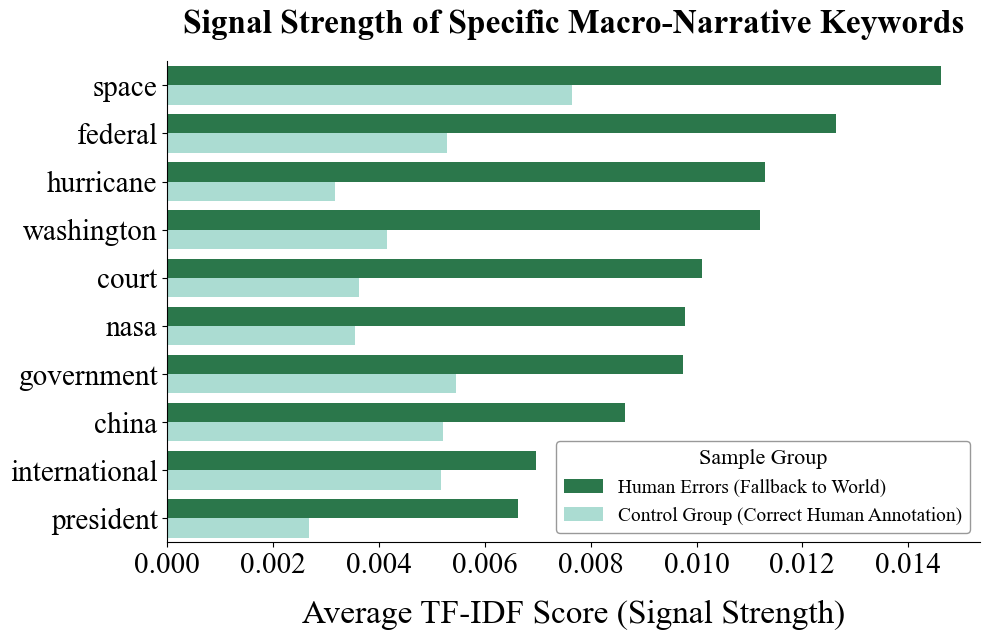


✅ 绘图完成。


In [ ]:
# 导入所需的核心库
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# --- 0. 初始化：下载NLTK依赖包 (如果已下载，此步会跳过) ---
try:
    stopwords.words('english')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

# --- 1. 配置与数据加载 ---
# (这部分与之前的定量分析代码完全相同)
FILE_PATH = 'NoisyAG-News_regenerated.pkl'
KEYWORDS_PATH = 'V_biz_keywords.txt'
LLM_COLUMN = 'gemini_2.5_pro_label'
GT_COLUMN = 'ground_truth'
SCI_TECH_LABEL = 3
BUSINESS_LABEL = 2

df = pd.read_pickle(FILE_PATH)
with open(KEYWORDS_PATH, 'r') as f:
    v_biz_keywords = set(f.read().splitlines())

# --- 2. 核心集合构建与匹配 ---
# (与之前的代码完全相同，以确保数据一致)
sci_tech_samples = df[df[GT_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == BUSINESS_LABEL].copy()
correct_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == SCI_TECH_LABEL].copy()

confusion_df['text_length'] = confusion_df['text'].str.len()
correct_df['text_length'] = correct_df['text'].str.len()
source_lengths = confusion_df['text_length'].values
target_lengths = correct_df['text_length'].values
matched_indices = []
available_target_indices = list(range(len(correct_df)))
for i in range(len(confusion_df)):
    source_len = source_lengths[i]
    diffs = np.abs(target_lengths[available_target_indices] - source_len)
    best_match_local_idx = np.argmin(diffs)
    best_match_global_idx = available_target_indices.pop(best_match_local_idx)
    matched_indices.append(best_match_global_idx)
matched_correct_df = correct_df.iloc[matched_indices].copy()
matched_confusion_df = confusion_df

# --- 3. 计算商业术语密度 ---
# (与之前的代码完全相同)
stop_words = set(stopwords.words('english'))
def calculate_density(text, keyword_set):
    tokens = word_tokenize(text.lower())
    content_words = [word for word in tokens if word.isalpha() and word not in stop_words]
    if len(content_words) == 0: return 0.0
    keyword_count = sum(1 for word in content_words if word in keyword_set)
    return keyword_count / len(content_words)

tqdm.pandas(desc="计算密度")
matched_confusion_df['density'] = matched_confusion_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)
matched_correct_df['density'] = matched_correct_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)




--- 正在生成可视化图表 ---
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Correct Set vs. Confusion Set: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.623e+06


✅ 图表已成功保存为 'business_term_density_comparison.pdf'


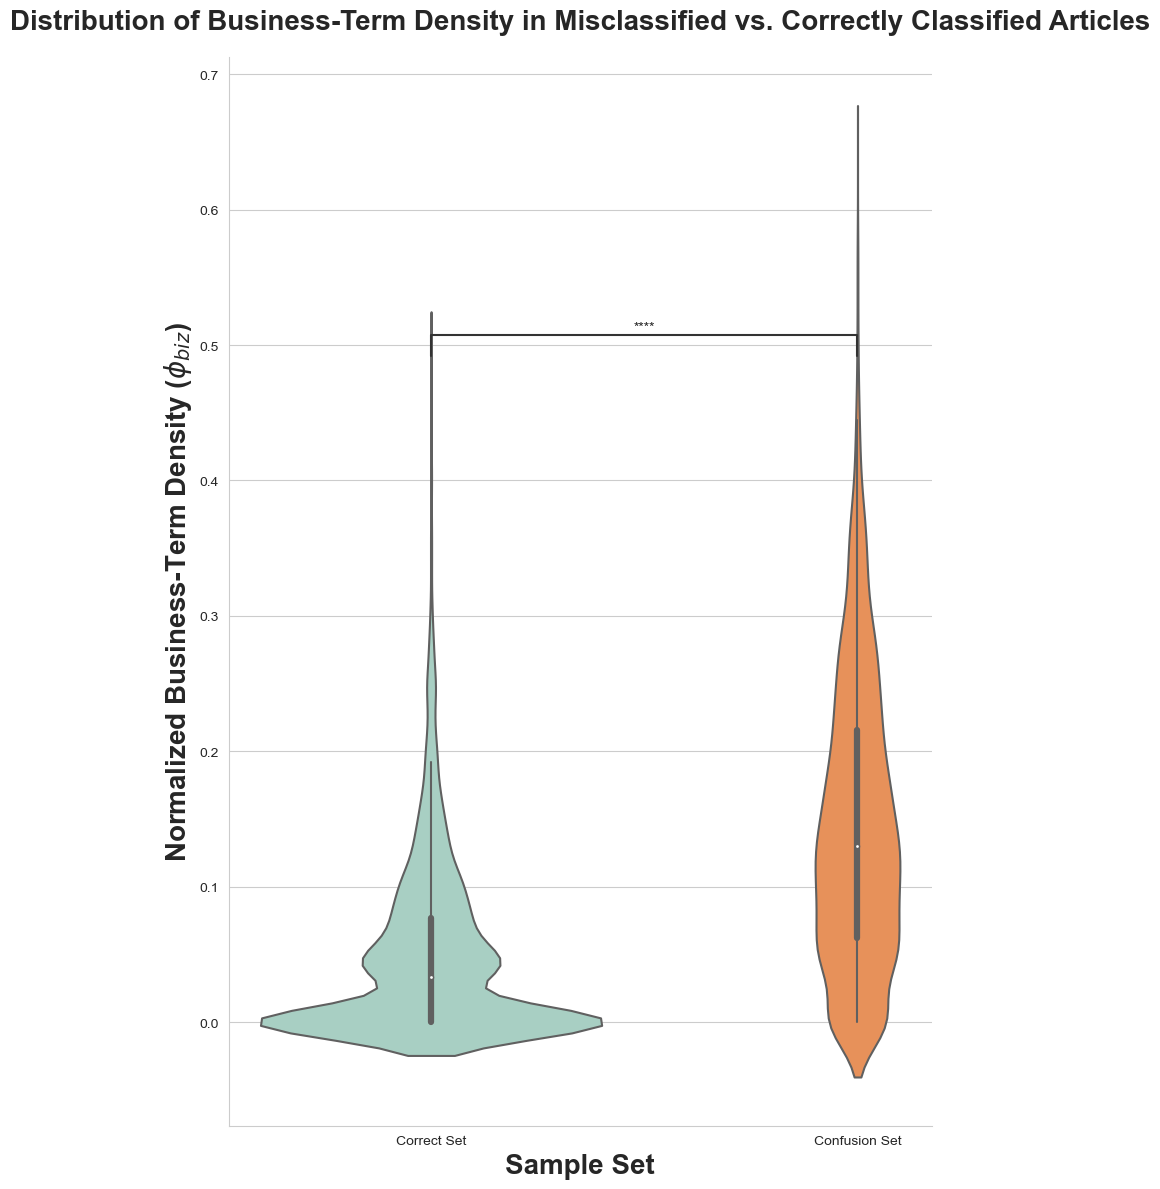

In [19]:
# --- 4. 可视化：创建小提琴图+箱形图 ---
# ==============================================================================
print("\n--- 正在生成可视化图表 ---")

# a. 准备绘图数据：将两个集合合并，并添加一个'group'列用于区分
matched_confusion_df['group'] = 'Confusion Set'
matched_correct_df['group'] = 'Correct Set'
plot_df = pd.concat([matched_confusion_df, matched_correct_df])

# b. 设置图表样式和参数
sns.set_style("whitegrid") # 设置专业、清爽的网格背景
plt.figure(figsize=(8,12)) # 设置图表大小

# c. 绘制核心图表：小提琴图内部嵌入箱形图
ax = sns.violinplot(
    data=plot_df,
    x='group',
    y='density',
    order=['Correct Set', 'Confusion Set'], # 指定X轴顺序
    palette=['#a2d5c6', '#ff8c42'],      # 指定柔和且对比鲜明的颜色
    inner='box'                         # 在小提琴内部绘制箱形图
)

# d. 添加统计显著性注释
# 定义要比较的组别
pairs = [('Correct Set', 'Confusion Set')]
# 初始化注释器
annotator = Annotator(ax, pairs, data=plot_df, x='group', y='density', order=['Correct Set', 'Confusion Set'])
# 配置并应用注释：使用曼-惠特尼U检验，并以星号显示p值
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

# e. 美化图表
ax.set_title(
    'Distribution of Business-Term Density in Misclassified vs. Correctly Classified Articles',
    fontsize=20,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Sample Set', fontsize=20, fontweight='bold')
ax.set_ylabel(r'Normalized Business-Term Density ($\phi_{biz}$)', fontsize=20, fontweight='bold')
sns.despine() # 移除顶部和右侧的轴线，使图表更开放
plt.tight_layout() # 自动调整布局

# f. 保存并显示图表
output_filename = 'business_term_density_comparison.pdf'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"✅ 图表已成功保存为 '{output_filename}'")
plt.show()

计算密度: 100%|██████████| 4190/4190 [00:01<00:00, 2746.63it/s]



--- 正在生成复合可视化图表 ---
Correct Set vs. Confusion Set: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.623e+06
✅ 复合图表已成功保存为 'composite_bias_analysis.pdf'


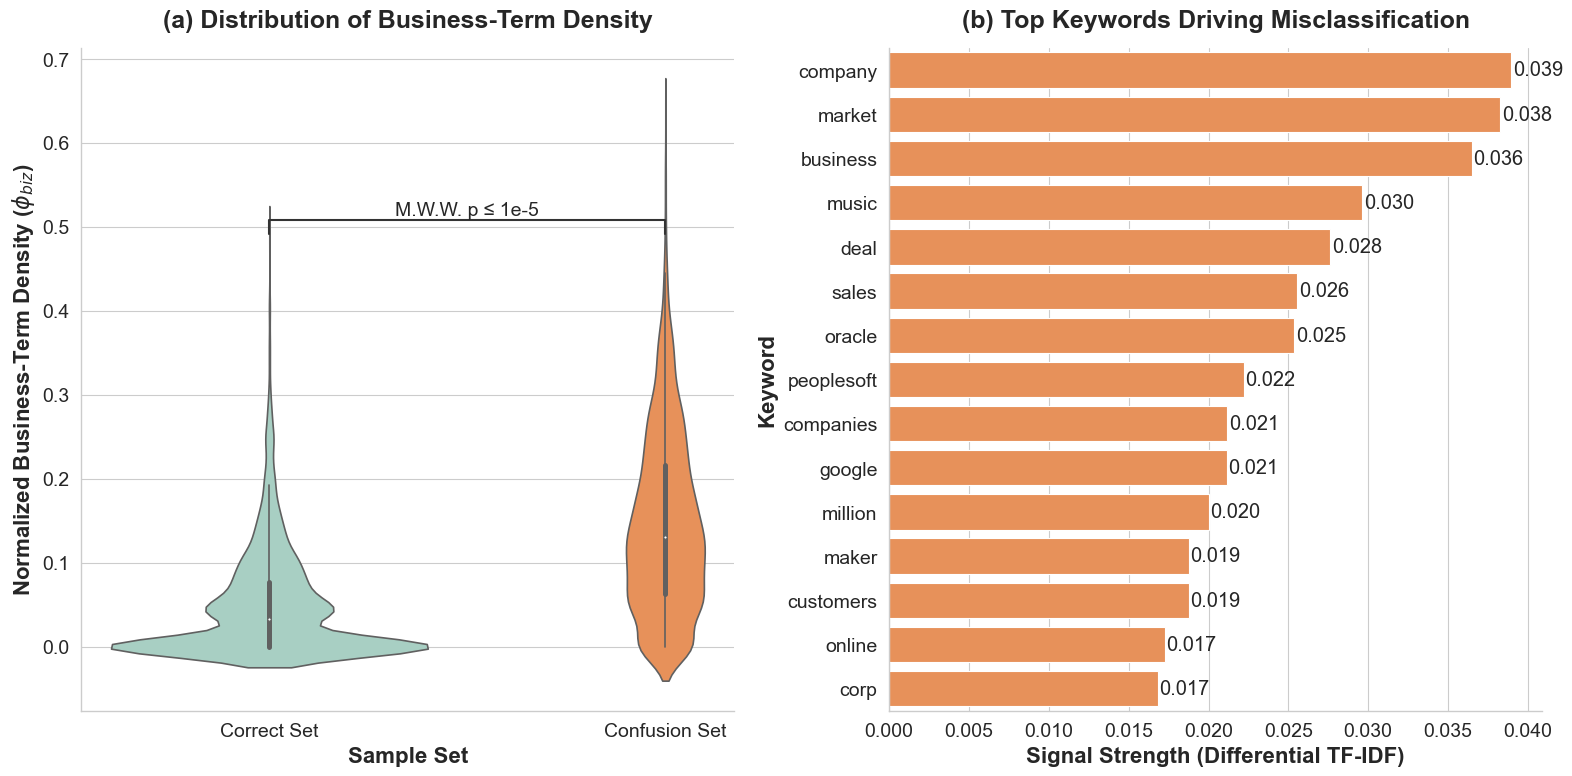

In [ ]:
# 导入所需的核心库
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 0. 初始化与配置 ---
# ==============================================================================
# 下载NLTK依赖包 (如果已下载，此步会跳过)
try:
    stopwords.words('english')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

# [优化] 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# --- 1. 数据加载与准备 ---
# ==============================================================================
# (与之前的代码完全相同)
FILE_PATH = 'NoisyAG-News_regenerated.pkl'
KEYWORDS_PATH = 'V_biz_keywords.txt'
LLM_COLUMN = 'gemini_2.5_pro_label'
GT_COLUMN = 'ground_truth'
SCI_TECH_LABEL = 3
BUSINESS_LABEL = 2

df = pd.read_pickle(FILE_PATH)
with open(KEYWORDS_PATH, 'r') as f:
    v_biz_keywords = set(f.read().splitlines())

# --- 2. 核心集合构建与匹配 ---
# ==============================================================================
# (与之前的代码完全相同)
sci_tech_samples = df[df[GT_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == BUSINESS_LABEL].copy()
correct_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df['text_length'] = confusion_df['text'].str.len()
correct_df['text_length'] = correct_df['text'].str.len()
source_lengths = confusion_df['text_length'].values
target_lengths = correct_df['text_length'].values
matched_indices = []
available_target_indices = list(range(len(correct_df)))
for i in range(len(confusion_df)):
    source_len = source_lengths[i]
    diffs = np.abs(target_lengths[available_target_indices] - source_len)
    best_match_local_idx = np.argmin(diffs)
    best_match_global_idx = available_target_indices.pop(best_match_local_idx)
    matched_indices.append(best_match_global_idx)
matched_correct_df = correct_df.iloc[matched_indices].copy()
matched_confusion_df = confusion_df

# --- 3. 计算商业术语密度 ---
# ==============================================================================
# (与之前的代码完全相同)
stop_words = set(stopwords.words('english'))
def calculate_density(text, keyword_set):
    tokens = word_tokenize(text.lower())
    content_words = [word for word in tokens if word.isalpha() and word not in stop_words]
    if len(content_words) == 0: return 0.0
    keyword_count = sum(1 for word in content_words if word in keyword_set)
    return keyword_count / len(content_words)
tqdm.pandas(desc="计算密度")
matched_confusion_df['density'] = matched_confusion_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)
matched_correct_df['density'] = matched_correct_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)

# --- 4. [新增] 计算关键词信号强度，用于绘制条形图 ---
# ==============================================================================
# (此部分逻辑正确，无需改动)
corpus = pd.concat([matched_confusion_df['text'], matched_correct_df['text']])
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7, lowercase=True, vocabulary=v_biz_keywords)
vectorizer.fit(corpus)
tfidf_confusion = vectorizer.transform(matched_confusion_df['text'])
tfidf_correct = vectorizer.transform(matched_correct_df['text'])
avg_tfidf_confusion = np.array(tfidf_confusion.mean(axis=0)).flatten()
avg_tfidf_correct = np.array(tfidf_correct.mean(axis=0)).flatten()
signal_strength = avg_tfidf_confusion - avg_tfidf_correct
results_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'signal_strength': signal_strength
})
results_df = results_df.sort_values(by='signal_strength', ascending=False)
top_keywords_df = results_df.head(15)





--- 正在生成复合可视化图表 ---
Correct Set vs. Confusion Set: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.623e+06
✅ 复合图表已成功保存为 'composite_bias_analysis.pdf'


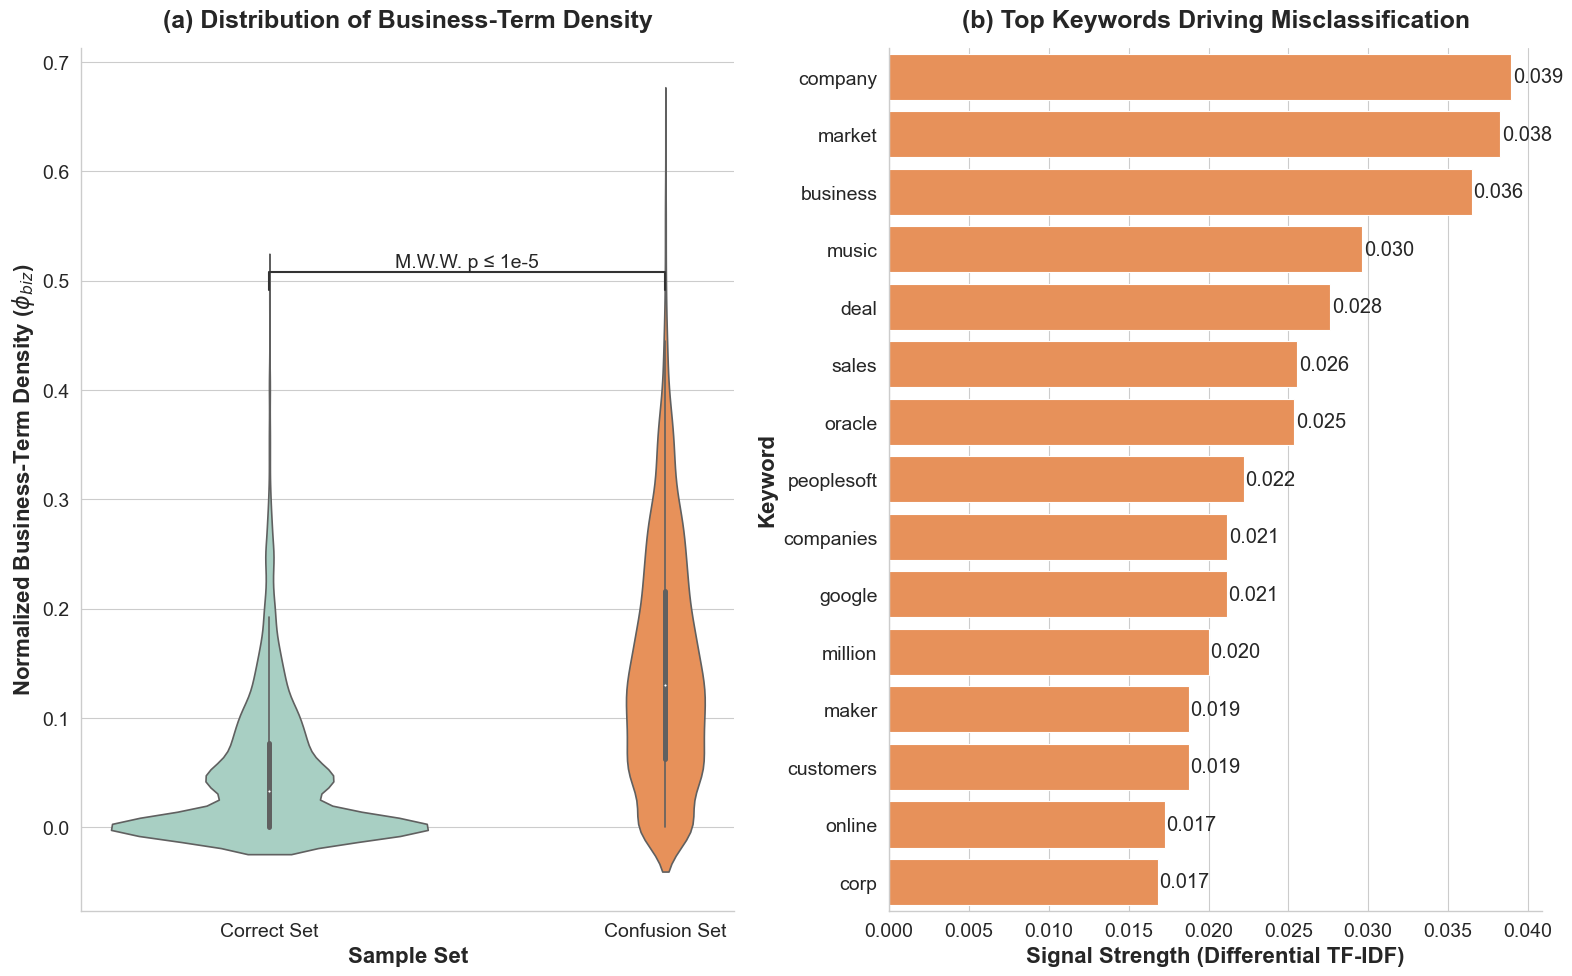

In [22]:
# --- 5. 可视化：创建双图联动的复合图表 ---
# ==============================================================================
print("\n--- 正在生成复合可视化图表 ---")

# a. 准备绘图数据
# [修正] 在合并(concat)之前，为每个DataFrame分别创建'group'列
matched_confusion_df['group'] = 'Confusion Set'
matched_correct_df['group'] = 'Correct Set'
plot_df = pd.concat([matched_confusion_df, matched_correct_df])

# 现在 plot_df 中已经包含了 'group' 列，可以安全地进行重命名和绘图
plot_df.rename(columns={
    'group': 'Sample Set', 
    'density': r'Normalized Business-Term Density ($\phi_{biz}$)'
    }, inplace=True)

# b. 设置全局主题和元素缩放
sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)

# c. 创建一个 1x2 的子图网格
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# --- 绘制左侧子图 (Panel A): 小提琴图 ---
ax1 = axes[0]
sns.violinplot(
    data=plot_df,
    x='Sample Set',
    y=r'Normalized Business-Term Density ($\phi_{biz}$)',
    order=['Correct Set', 'Confusion Set'],
    palette=['#a2d5c6', '#ff8c42'],
    inner='box',
    ax=ax1
)
pairs = [('Correct Set', 'Confusion Set')]
annotator = Annotator(ax1, pairs, data=plot_df, x='Sample Set', y=r'Normalized Business-Term Density ($\phi_{biz}$)', order=['Correct Set', 'Confusion Set'])
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', fontsize=14)
annotator.apply_and_annotate()
ax1.set_title('(a) Distribution of Business-Term Density', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel('Sample Set', fontsize=16, fontweight='bold')
ax1.set_ylabel(r'Normalized Business-Term Density ($\phi_{biz}$)', fontsize=16, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=14)

# --- 绘制右侧子图 (Panel B): 关键词条形图 ---
ax2 = axes[1]
sns.barplot(
    data=top_keywords_df,
    x='signal_strength',
    y='term',
    color='#ff8c42',
    ax=ax2
)
ax2.set_title('(b) Top Keywords Driving Misclassification', fontsize=18, fontweight='bold', pad=15)
ax2.set_xlabel('Signal Strength (Differential TF-IDF)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Keyword', fontsize=16, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=14)
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.0001, p.get_y() + p.get_height() / 2., f'{width:.3f}', va='center')


# d. 全局美化与保存
sns.despine(fig=fig)
plt.tight_layout()
output_filename = 'composite_bias_analysis.pdf'
plt.savefig(output_filename, bbox_inches='tight')
print(f"✅ 复合图表已成功保存为 '{output_filename}'")
plt.show()

计算密度: 100%|██████████| 4190/4190 [00:01<00:00, 2757.12it/s]



--- 正在生成复合可视化图表 ---
✅ 复合图表已成功保存为 'composite_bias_analysis_optimized.pdf'


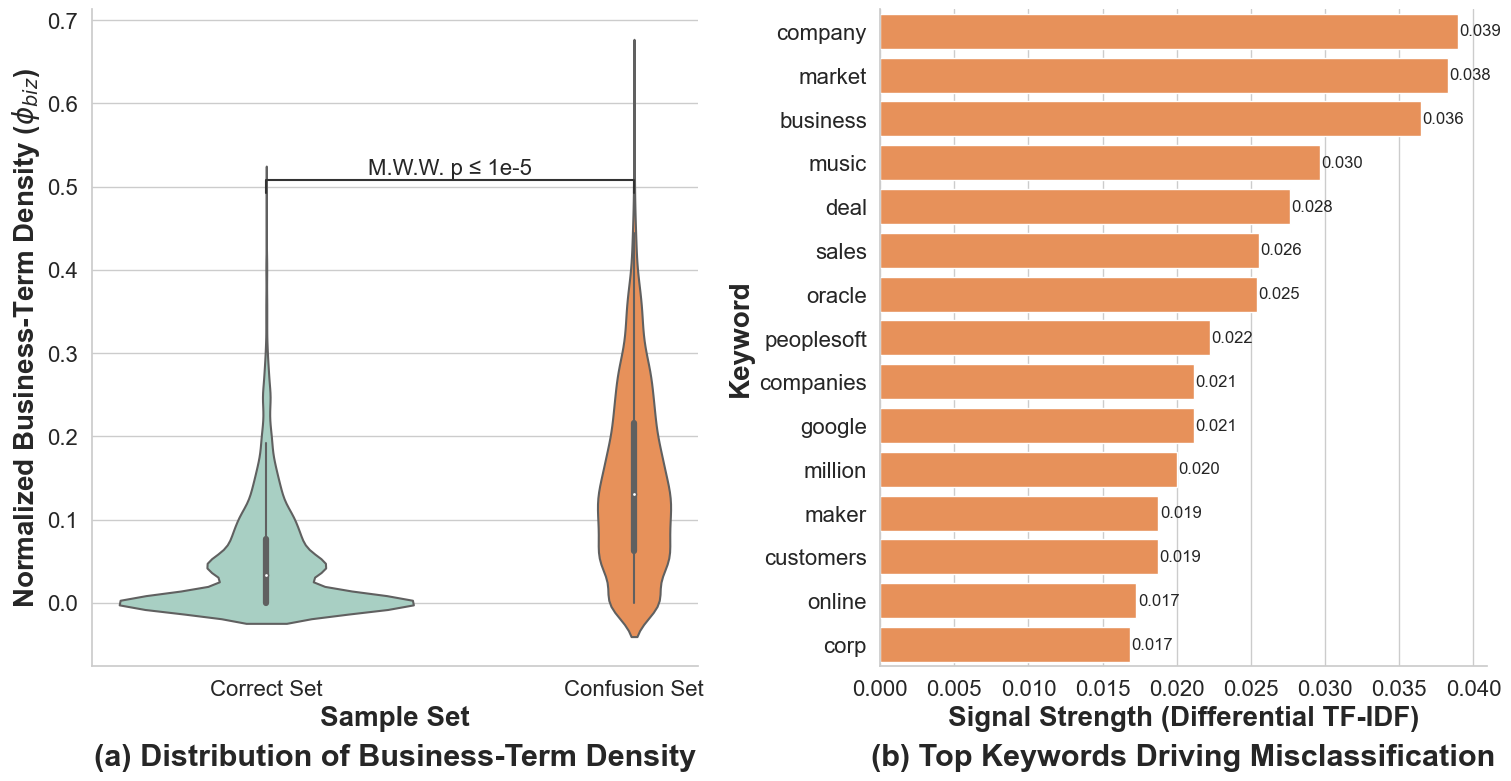

In [23]:
# 导入所需的核心库
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 0. 初始化与配置 ---
# ==============================================================================
# 下载NLTK依赖包 (如果已下载，此步会跳过)
try:
    stopwords.words('english')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

# --- [优化] 1. 样式与字体配置区 ---
# ==============================================================================
# 在这里自由调节所有字体和尺寸！
TITLE_FONTSIZE = 22       # 子图标题的字号
LABEL_FONTSIZE = 20       # X, Y轴标签的字号
TICK_FONTSIZE = 16        # X, Y轴刻度标签的字号
ANNOTATION_FONTSIZE = 16  # P值注释的字号
BAR_LABEL_FONTSIZE = 12   # 条形图上数值标签的字号

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# 解决在某些系统上可能出现的负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# --- 2. 数据加载与准备 ---
# ==============================================================================
FILE_PATH = 'NoisyAG-News_regenerated.pkl'
KEYWORDS_PATH = 'V_biz_keywords.txt'
LLM_COLUMN = 'gemini_2.5_pro_label'
GT_COLUMN = 'ground_truth'
SCI_TECH_LABEL = 3
BUSINESS_LABEL = 2
df = pd.read_pickle(FILE_PATH)
with open(KEYWORDS_PATH, 'r') as f:
    v_biz_keywords = set(f.read().splitlines())

# --- 3. 核心集合构建与匹配 ---
# ==============================================================================
sci_tech_samples = df[df[GT_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == BUSINESS_LABEL].copy()
correct_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df['text_length'] = confusion_df['text'].str.len()
correct_df['text_length'] = correct_df['text'].str.len()
source_lengths = confusion_df['text_length'].values
target_lengths = correct_df['text_length'].values
matched_indices = []
available_target_indices = list(range(len(correct_df)))
for i in range(len(confusion_df)):
    source_len = source_lengths[i]
    diffs = np.abs(target_lengths[available_target_indices] - source_len)
    best_match_local_idx = np.argmin(diffs)
    best_match_global_idx = available_target_indices.pop(best_match_local_idx)
    matched_indices.append(best_match_global_idx)
matched_correct_df = correct_df.iloc[matched_indices].copy()
matched_confusion_df = confusion_df

# --- 4. 计算商业术语密度与关键词信号强度 ---
# ==============================================================================
stop_words = set(stopwords.words('english'))
def calculate_density(text, keyword_set):
    tokens = word_tokenize(text.lower())
    content_words = [word for word in tokens if word.isalpha() and word not in stop_words]
    if len(content_words) == 0: return 0.0
    keyword_count = sum(1 for word in content_words if word in keyword_set)
    return keyword_count / len(content_words)
tqdm.pandas(desc="计算密度")
matched_confusion_df['density'] = matched_confusion_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)
matched_correct_df['density'] = matched_correct_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)

corpus = pd.concat([matched_confusion_df['text'], matched_correct_df['text']])
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7, lowercase=True, vocabulary=v_biz_keywords)
vectorizer.fit(corpus)
tfidf_confusion = vectorizer.transform(matched_confusion_df['text'])
tfidf_correct = vectorizer.transform(matched_correct_df['text'])
avg_tfidf_confusion = np.array(tfidf_confusion.mean(axis=0)).flatten()
avg_tfidf_correct = np.array(tfidf_correct.mean(axis=0)).flatten()
signal_strength = avg_tfidf_confusion - avg_tfidf_correct
results_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(),'signal_strength': signal_strength})
results_df = results_df.sort_values(by='signal_strength', ascending=False)
top_keywords_df = results_df.head(15)

# --- 5. 可视化：创建双图联动的复合图表 ---
# ==============================================================================
print("\n--- 正在生成复合可视化图表 ---")

# a. 准备绘图数据
matched_confusion_df['group'] = 'Confusion Set'
matched_correct_df['group'] = 'Correct Set'
plot_df = pd.concat([matched_confusion_df, matched_correct_df])
plot_df.rename(columns={'group': 'Sample Set', 'density': r'Normalized Business-Term Density ($\phi_{biz}$)'}, inplace=True)

# b. 设置全局 seaborn 主题
sns.set_theme(style="whitegrid")

# c. 创建一个 1x2 的子图网格
fig, axes = plt.subplots(1, 2, figsize=(18, 9)) # 稍微调整了尺寸比例

# --- 绘制左侧子图 (Panel A): 小提琴图 ---
ax1 = axes[0]
sns.violinplot(
    data=plot_df, x='Sample Set', y=r'Normalized Business-Term Density ($\phi_{biz}$)',
    order=['Correct Set', 'Confusion Set'], palette=['#a2d5c6', '#ff8c42'],
    inner='box', ax=ax1
)
pairs = [('Correct Set', 'Confusion Set')]
annotator = Annotator(ax1, pairs, data=plot_df, x='Sample Set', y=r'Normalized Business-Term Density ($\phi_{biz}$)', order=['Correct Set', 'Confusion Set'])
# [优化] 修改注释格式为p值，并使用配置变量控制字体大小
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', fontsize=ANNOTATION_FONTSIZE, verbose=0)
annotator.apply_and_annotate()
ax1.set_xlabel('Sample Set', fontsize=LABEL_FONTSIZE, fontweight='bold')
ax1.set_ylabel(r'Normalized Business-Term Density ($\phi_{biz}$)', fontsize=LABEL_FONTSIZE, fontweight='bold')
# [优化] 使用配置变量增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
# [优化] 将标题移动到图下方
ax1.set_title("") # 清空顶部标题
ax1.text(0.5, -0.15, '(a) Distribution of Business-Term Density', 
         transform=ax1.transAxes, ha='center', 
         fontsize=TITLE_FONTSIZE, fontweight='bold')


# --- 绘制右侧子图 (Panel B): 关键词条形图 ---
ax2 = axes[1]
sns.barplot(data=top_keywords_df, x='signal_strength', y='term', color='#ff8c42', ax=ax2)
ax2.set_xlabel('Signal Strength (Differential TF-IDF)', fontsize=LABEL_FONTSIZE, fontweight='bold')
ax2.set_ylabel('Keyword', fontsize=LABEL_FONTSIZE, fontweight='bold')
# [优化] 使用配置变量增大刻度字体
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
# [优化] 为条形图上的数值标签使用配置变量
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.0001, p.get_y() + p.get_height() / 2., f'{width:.3f}', 
             va='center', fontsize=BAR_LABEL_FONTSIZE)
# [优化] 将标题移动到图下方
ax2.set_title("") # 清空顶部标题
ax2.text(0.5, -0.15, '(b) Top Keywords Driving Misclassification', 
         transform=ax2.transAxes, ha='center', 
         fontsize=TITLE_FONTSIZE, fontweight='bold')


# d. 全局美化与保存
sns.despine(fig=fig)
# 调整子图间距和底部边距，为下方的标题留出空间
plt.subplots_adjust(bottom=0.15, wspace=0.3)
output_filename = 'composite_bias_analysis_optimized.pdf'
plt.savefig(output_filename, bbox_inches='tight')
print(f"✅ 复合图表已成功保存为 '{output_filename}'")
plt.show()

In [13]:
# 导入所需的核心库
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import re

# --- 0. 初始化与函数定义 ---
# ==============================================================================
# 确保NLTK依赖包已下载
try:
    stopwords.words('english')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

def highlight_keywords(text, keyword_set):
    """
    高亮显示文本中的关键词。
    这个版本更智能，能处理标点符号并保留原始大小写。
    """
    highlighted_parts = []
    # 使用正则表达式按单词和非单词字符分割文本，保留所有部分
    tokens_and_delimiters = re.split(r'(\W+)', text)
    
    for part in tokens_and_delimiters:
        # 如果部分是单词，并且其小写形式在关键词集合中
        if part.lower() in keyword_set and re.match(r'\w+', part):
            highlighted_parts.append(f"**{part}**") # 使用Markdown加粗格式高亮
        else:
            highlighted_parts.append(part)
            
    return "".join(highlighted_parts)

# --- 1. 配置与数据加载 ---
# (与之前的代码完全相同)
FILE_PATH = 'NoisyAG-News_regenerated.pkl'
KEYWORDS_PATH = 'V_biz_keywords.txt'
LLM_COLUMN = 'gemini_2.5_pro_label'
GT_COLUMN = 'ground_truth'
SCI_TECH_LABEL = 3
BUSINESS_LABEL = 2

df = pd.read_pickle(FILE_PATH)
with open(KEYWORDS_PATH, 'r') as f:
    v_biz_keywords = set(f.read().splitlines())

# --- 2. 核心集合构建与匹配 ---
# (与之前的代码完全相同)
sci_tech_samples = df[df[GT_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == BUSINESS_LABEL].copy()
correct_df = sci_tech_samples[sci_tech_samples[LLM_COLUMN] == SCI_TECH_LABEL].copy()
confusion_df['text_length'] = confusion_df['text'].str.len()
correct_df['text_length'] = correct_df['text'].str.len()
source_lengths = confusion_df['text_length'].values
target_lengths = correct_df['text_length'].values
matched_indices = []
available_target_indices = list(range(len(correct_df)))
for i in range(len(confusion_df)):
    source_len = source_lengths[i]
    diffs = np.abs(target_lengths[available_target_indices] - source_len)
    best_match_local_idx = np.argmin(diffs)
    best_match_global_idx = available_target_indices.pop(best_match_local_idx)
    matched_indices.append(best_match_global_idx)
matched_correct_df = correct_df.iloc[matched_indices].copy()
matched_confusion_df = confusion_df

# --- 3. 计算商业术语密度 ---
# (与之前的代码完全相同)
stop_words = set(stopwords.words('english'))
def calculate_density(text, keyword_set):
    tokens = word_tokenize(text.lower())
    content_words = [word for word in tokens if word.isalpha() and word not in stop_words]
    if len(content_words) == 0: return 0.0
    keyword_count = sum(1 for word in content_words if word in keyword_set)
    return keyword_count / len(content_words)

tqdm.pandas(desc="计算密度")
matched_confusion_df['density'] = matched_confusion_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)
matched_correct_df['density'] = matched_correct_df['text'].progress_apply(calculate_density, keyword_set=v_biz_keywords)

# --- 4. 自动挖掘并呈现案例 ---
# ==============================================================================
print("\n" + "="*25 + " 🔬 定性案例分析 🔬 " + "="*25)

# a. 从“混淆集”中找到密度最高的“典型错误样本”
prototypical_case = matched_confusion_df.sort_values(by='density', ascending=False).iloc[0]

print("\n--- 1. 典型错误样本 (来自混淆集) ---\n")
print(f"真实标签 (GT): Sci/Tech")
print(f"LLM 错误标签: Business")
print(f"🔥 计算出的商业术语密度: {prototypical_case['density']:.2%}\n")
print("--- 文本内容 (关键词已高亮) ---\n")
highlighted_text_proto = highlight_keywords(prototypical_case['text'], v_biz_keywords)
print(highlighted_text_proto)
print("\n" + "-"*70)

# b. 从“正确集”中找到包含关键词但密度最低的“完美反例”
#   1. 先筛选出密度 > 0 的样本（确保至少包含一个关键词）
#   2. 然后从这些样本中找到密度最低的
correct_with_keywords = matched_correct_df[matched_correct_df['density'] > 0]
if not correct_with_keywords.empty:
    counterexample_case = correct_with_keywords.sort_values(by='density', ascending=True).iloc[0]
    
    print("\n--- 2. 完美反例样本 (来自正确集) ---\n")
    print(f"真实标签 (GT): Sci/Tech")
    print(f"LLM 正确标签: Sci/Tech")
    print(f"✅ 计算出的商业术语密度: {counterexample_case['density']:.2%}\n")
    print("--- 文本内容 (关键词已高亮) ---\n")
    highlighted_text_counter = highlight_keywords(counterexample_case['text'], v_biz_keywords)
    print(highlighted_text_counter)
    print("\n" + "-"*70)
else:
    print("\n在匹配后的正确集中未找到包含任何致偏关键词的样本，无法生成反例。")

print("\n✅ 定性案例挖掘完成。")

计算密度: 100%|██████████| 4190/4190 [00:01<00:00, 3048.54it/s]


========================= 🔬 定性案例分析 🔬 =========================

--- 1. 典型错误样本 (来自混淆集) ---

真实标签 (GT): Sci/Tech
LLM 错误标签: Business
🔥 计算出的商业术语密度: 63.64%

--- 文本内容 (关键词已高亮) ---

**Yahoo** to **Buy** Digital **Music** **Company** Musicmatch (**Reuters**) . **Reuters** - Internet **company** **Yahoo** Inc. \**said** on Tuesday it will **buy** privately held **music** **software**\**company** Musicmatch Inc. for about  #**36**;160 **million** in a bid to\bolster its **online** **music** **services**.

----------------------------------------------------------------------

--- 2. 完美反例样本 (来自正确集) ---

真实标签 (GT): Sci/Tech
LLM 正确标签: Sci/Tech
✅ 计算出的商业术语密度: 1.67%

--- 文本内容 (关键词已高亮) ---

More Confirmation Mars Had Large Seas . Boulder, CO -- Spacecraft observations of the landing area for one of NASA's two Mars rovers now indicate there likely was an enormous sea or lake covering the region in the past, according to a new University of Colorado at Boulder study.     Research Associate Brian Hynek o

正在生成关键词信号强度条形图...


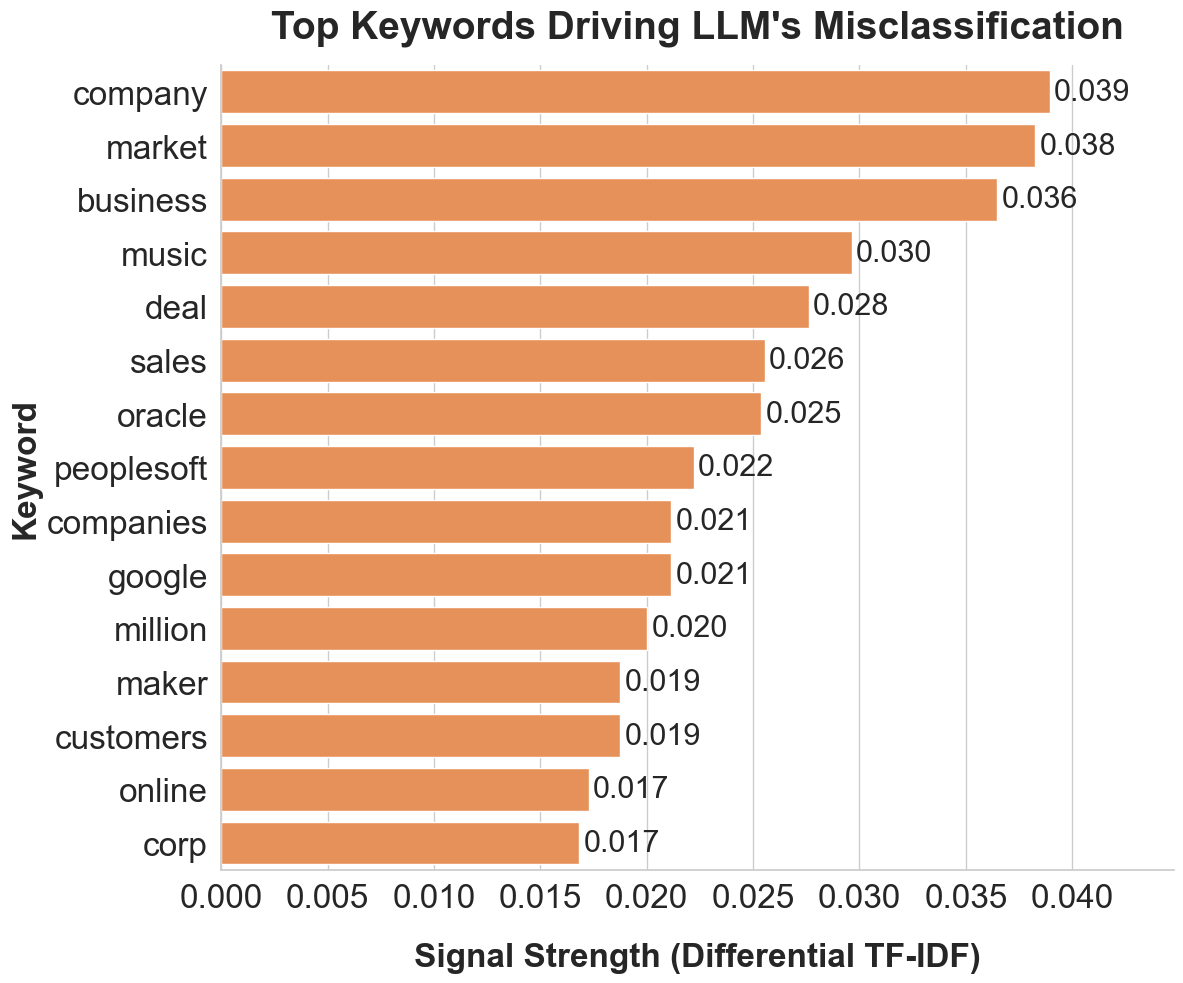

✅ 图表已成功保存为 'sec5_keywords_barchart.pdf'


In [52]:
# 导入所需的核心库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# --- [优化] 1. 样式与字体配置区 ---
# ==============================================================================
# 在这里自由调节所有字体和尺寸！
# (请确保您的系统中已安装 'Times New Roman' 字体)
TITLE_FONTSIZE = 28       # 图表标题的字号
LABEL_FONTSIZE = 24       # X, Y轴标签的字号
TICK_FONTSIZE = 24        # X, Y轴刻度标签的字号
BAR_LABEL_FONTSIZE = 22   # 条形图上数值标签的字号
X_LABEL_PADDING = 20      # X轴刻度与X轴标签之间的距离

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.unicode_minus'] = False


# --- 2. 数据准备 ---
# ==============================================================================
# (此部分为示例数据，请确保 top_keywords_df 的来源与您之前的脚本一致)
# 假设 top_keywords_df 是已经计算好的、包含 'term' 和 'signal_strength' 列的DataFrame
# 例如:
# top_keywords_df = pd.DataFrame({
#     'term': ['company', 'market', 'business', 'music', 'deal'],
#     'signal_strength': [0.039, 0.038, 0.036, 0.030, 0.028]
# }).sort_values(by='signal_strength', ascending=False)


# --- 3. 可视化函数 ---
# ==============================================================================
def plot_keyword_signal_strength(data_df):
    """
    绘制并保存关键词信号强度的条形图。
    """
    print("正在生成关键词信号强度条形图...")
    
    # a. 设置 seaborn 主题
    sns.set_theme(style="whitegrid")
    
    # b. 创建画布和坐标轴，并设定尺寸
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # c. 绘制核心图表
    sns.barplot(data=data_df, x='signal_strength', y='term', color='#ff8c42', ax=ax)
    
    # d. 美化图表 (使用配置区的变量)
    ax.set_title("Top Keywords Driving LLM's Misclassification", 
                 fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
    ax.set_xlabel('Signal Strength (Differential TF-IDF)', 
                  fontsize=LABEL_FONTSIZE, fontweight='bold', labelpad=X_LABEL_PADDING)
    ax.set_ylabel('Keyword', 
                  fontsize=LABEL_FONTSIZE, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    
    # 为每个条形添加精确的数值标签
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.0002,  # 标签的水平位置 (在条形右侧)
                p.get_y() + p.get_height() / 2.,  # 标签的垂直位置 (与条形居中)
                f'{width:.3f}', 
                va='center', 
                fontsize=BAR_LABEL_FONTSIZE)
    
    # 调整x轴的范围，为数值标签留出更多空间
    ax.set_xlim(right=data_df['signal_strength'].max() * 1.15)
    
    # e. 全局美化与保存
    sns.despine(fig=fig)
    plt.tight_layout()
    
    output_filename = 'sec5_keywords_barchart.pdf'
    plt.savefig(output_filename, bbox_inches='tight')
    plt.show()
    plt.close(fig) # 关闭画布，释放内存
    print(f"✅ 图表已成功保存为 '{output_filename}'")

# --- 4. 运行 ---
# ==============================================================================
# 假设 top_keywords_df 已经从您之前的完整脚本中计算得出
plot_keyword_signal_strength(top_keywords_df)


正在生成图 (b): 商业术语密度小提琴图...


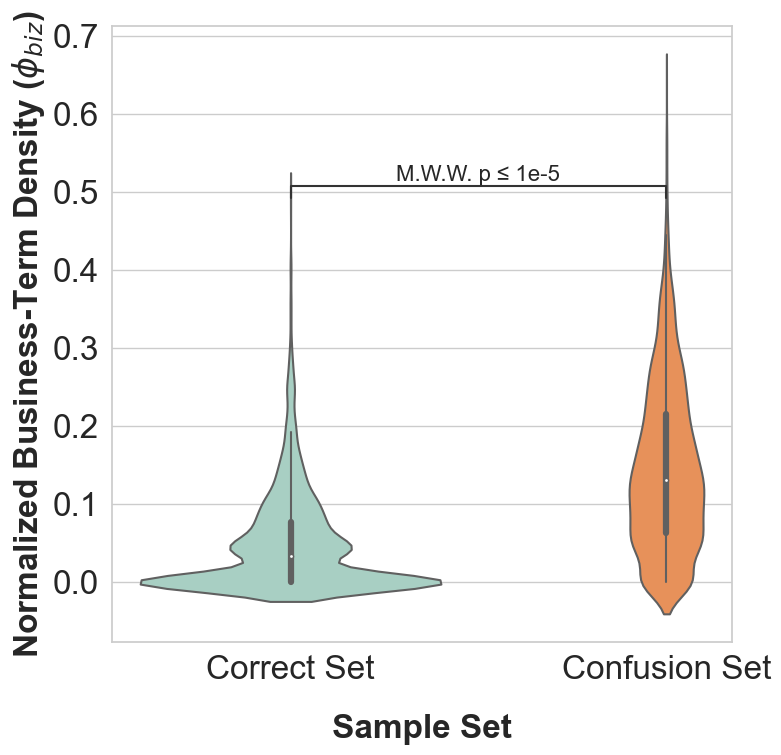

✅ 图表 (b) 已成功保存为 'sec5_b_density_violinplot.pdf'

所有独立的图表文件均已生成完毕。


In [53]:
# --- 5.2. 可视化并保存图 (b): 小提琴图 ---
# ------------------------------------------------------------------------------
print("\n正在生成图 (b): 商业术语密度小提琴图...")
# a. 准备绘图数据
matched_confusion_df['group'] = 'Confusion Set'
matched_correct_df['group'] = 'Correct Set'
plot_df = pd.concat([matched_confusion_df, matched_correct_df])
plot_df.rename(columns={'group': 'Sample Set', 'density': r'Normalized Business-Term Density ($\phi_{biz}$)'}, inplace=True)
# b. 单独创建画布和坐标轴
fig2, ax2 = plt.subplots(figsize=(8, 8))
# c. 绘制图表
sns.violinplot(
    data=plot_df, x='Sample Set', y=r'Normalized Business-Term Density ($\phi_{biz}$)',
    order=['Correct Set', 'Confusion Set'], palette=['#a2d5c6', '#ff8c42'],
    inner='box', ax=ax2
)
# d. 添加统计注释
pairs = [('Correct Set', 'Confusion Set')]
annotator = Annotator(ax2, pairs, data=plot_df, x='Sample Set', y=r'Normalized Business-Term Density ($\phi_{biz}$)', order=['Correct Set', 'Confusion Set'])
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', fontsize=ANNOTATION_FONTSIZE, verbose=0)
annotator.apply_and_annotate()
# e. 美化图表
ax2.set_xlabel('Sample Set', fontsize=LABEL_FONTSIZE, fontweight='bold', labelpad=X_LABEL_PADDING)
ax2.set_ylabel(r'Normalized Business-Term Density ($\phi_{biz}$)', fontsize=LABEL_FONTSIZE, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
# f. 保存文件
output_filename_b = 'sec5_b_density_violinplot.pdf'
plt.savefig(output_filename_b, bbox_inches='tight')
plt.show()
plt.close(fig2) # 关闭画布
print(f"✅ 图表 (b) 已成功保存为 '{output_filename_b}'")

print("\n所有独立的图表文件均已生成完毕。")